In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs

from scsavailability import features as feat, model as md, plotting as pt

In [2]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201123.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-2511.csv')
fa = pd.read_csv(path + 'scs_tote_matched.csv')

In [4]:
at = feat.pre_process_AT(at)

Active Totes Preprocessed


In [5]:
av = feat.pre_process_av(av)

Quadrants Assigned
Modules Assigned
Availability data pre-processed


In [6]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

duplicated location faults removed - max duration kept
Faults Preprocessed


C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = pd.to_timedelta(fa['Duration'].str.slice(start=2))
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = fa['Duration'].dt.total_seconds()


In [7]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

Time shifted by 0m


In [40]:
fa_sel = feat.fault_select(fa_floor, select_level = 'Tote Colour', selection = ['Blue','Both','Grey'])

fa_agg = feat.faults_aggregate(fa_sel,fault_agg_level='Number', agg_type = 'count')

Faults aggregated


In [41]:
av,at = feat.av_at_select(av, at, remove_high_AT = False)

av_agg = feat.aggregate_availability(av, agg_level = 'Quadrant')
at_agg = feat.aggregate_totes(at, agg_level = 'Quadrant')

Availability data aggregated


In [42]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, target = 'Downtime',faults=True, totes = True, agg_level = 'Quadrant')

Datasets merged


In [43]:
df.head(5)

,timestamp,Downtime,42023,42182,42329,42343,42375,42438,42442,42453,...,502793,502801,503060,503061,503098,503105,503114,503115,503123,TOTES
0,2020-11-17 09:00:00,0.404806,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,46.762069
1,2020-11-17 09:00:00,0.238825,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62.116959
2,2020-11-17 09:00:00,0.193512,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75.383966
3,2020-11-17 09:00:00,0.304642,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,46.250000
4,2020-11-17 10:00:00,0.403723,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,37.590000


In [44]:
#df = df[df['TOTES']<60].reset_index(drop=True)

In [45]:
X,y = md.gen_feat_var(df)

Feature Importance Ranking: 
 
    Importance Feature
0    0.558195   TOTES
1    0.015457   59331
2    0.012428   98597
3    0.007731  139558
4    0.007336  108581
5    0.006352   92867
6    0.005522  116581
7    0.004792  122348
8    0.004790   74773
9    0.004620  419818

Regression Metrics: 
 
           RF Metrics
MAE         0.059511
MSE         0.006322
RMSE        0.079508
MAPE%      17.660000
ACC%       82.340000
OOB         0.500325
R2_Train    0.927781
R2_Pred     0.578280 

Feature Coefficient Ranking: 
 
    Coefficients Feature
0 -1.962429e+09   42343
1 -1.796847e+09   42832
2 -1.277518e+09   43367
3 -1.260794e+09   42438
4 -9.872586e+08   42693
5 -9.392619e+08   42442
6 -5.568798e+08   42581
7 -4.701707e+08   42329
8 -4.442796e+08  419146
9 -4.200223e+08  130421

Regression Metrics: 
 
           LM Metrics
MAE         0.065773
MSE         0.007081
RMSE        0.084148
MAPE%      19.060000
ACC%       80.940000
R2_Train    0.787454
R2_Pred     0.527621

Cross Validation Sc

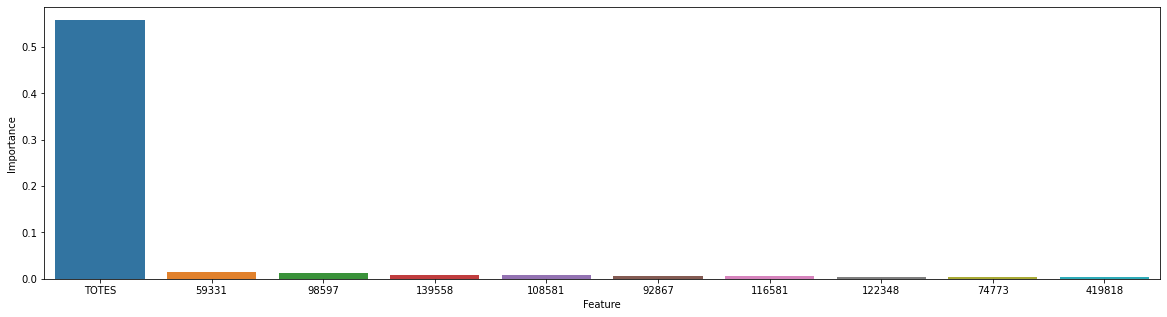

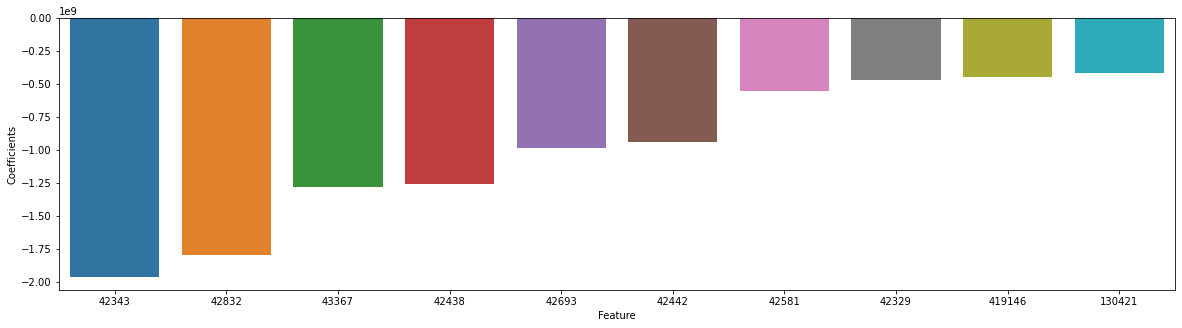

In [46]:
X_train, X_test, y_train, y_test = md.split(X,y,test_size=0.3,random_state=101)

RF_mdl,predictions_RF=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mse', max_depth=None, dtree=False)

#X_sel_rf = md.select_features(X, X_train, y_train, RF_mdl, thres = np.inf(), max_feat=1000)

Linear_mdl,predictions_LM=md.run_LR_model(X_train, X_test, y_train, y_test)

#X_sel_lm = md.select_features(X, X_train, y_train, Linear_mdl, thres = np.inf(), max_feat=1000)

cv_R2 = md.cross_validate_r2(Linear_mdl, X, y, n_folds = 10, shuffle = True, random_state = 101)

cv_R2 = md.cross_validate_r2(RF_mdl, X, y, n_folds = 10, shuffle = True, random_state = 101)